In [1]:
import pandas as pd

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words('english')]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Apply preprocessing to the 'statement' column
train_data['processed_text'] = train_data['statement'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from gensim import corpora

# Create a dictionary from the processed text
dictionary = corpora.Dictionary(train_data['processed_text'])

# Create a corpus: a list of bag-of-words representations of each document
corpus = [dictionary.doc2bow(text) for text in train_data['processed_text']]


In [15]:
from gensim.models.ldamodel import LdaModel

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=20)

# Print the topics discovered by the model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.034*"health" + 0.031*"care" + 0.021*"say" + 0.015*"bill" + 0.013*"american" + 0.012*"trump" + 0.011*"insurance" + 0.011*"law" + 0.009*"donald" + 0.009*"people"')
(1, '0.039*"say" + 0.013*"illegal" + 0.013*"support" + 0.012*"romney" + 0.012*"security" + 0.011*"mitt" + 0.010*"gun" + 0.009*"voted" + 0.009*"social" + 0.007*"republican"')
(2, '0.026*"state" + 0.011*"new" + 0.010*"city" + 0.010*"country" + 0.009*"united" + 0.009*"people" + 0.008*"say" + 0.007*"wage" + 0.006*"public" + 0.006*"law"')
(3, '0.036*"percent" + 0.029*"year" + 0.024*"tax" + 0.017*"state" + 0.010*"school" + 0.010*"job" + 0.009*"say" + 0.009*"last" + 0.009*"time" + 0.009*"one"')
(4, '0.024*"obama" + 0.019*"say" + 0.015*"tax" + 0.015*"president" + 0.012*"barack" + 0.012*"clinton" + 0.010*"plan" + 0.010*"hillary" + 0.010*"would" + 0.007*"business"')
(5, '0.030*"say" + 0.016*"president" + 0.012*"obama" + 0.012*"job" + 0.012*"state" + 0.010*"billion" + 0.010*"scott" + 0.009*"budget" + 0.009*"office" + 0.009*"gov"')

In [5]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the visualization as an HTML file
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

# Optionally, you can open it directly in the browser
import webbrowser
webbrowser.open('lda_visualization.html')


True

label           barely-true  false  half-true  mostly-true  pants-fire  true
dominant_topic                                                              
0                       233    289        235          227         140   208
1                       227    260        246          191         112   185
2                       178    241        266          259          89   230
3                       431    512        711          789         161   572
4                       225    307        247          170         146   171
5                       360    386        409          326         191   310


<Axes: xlabel='dominant_topic'>

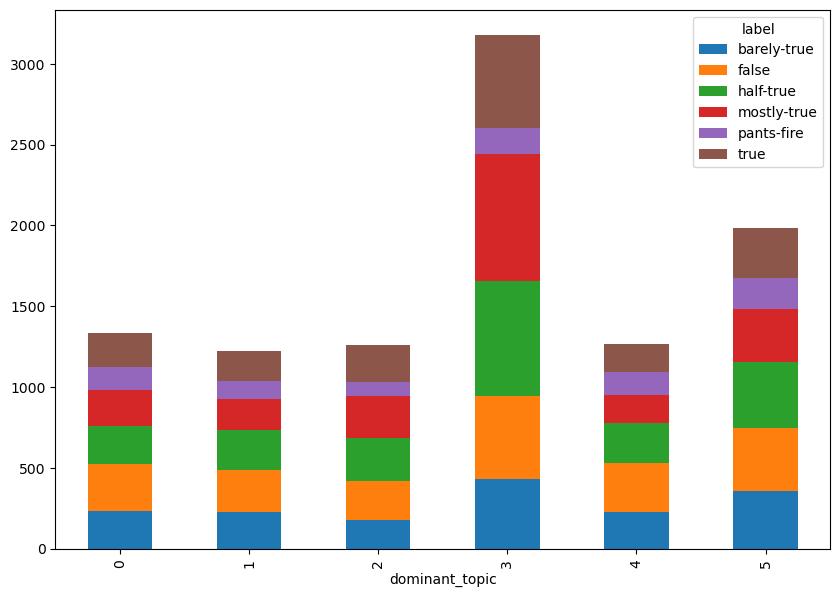

In [17]:
import pandas as pd
import numpy as np

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Display the distribution
print(label_distribution_by_topic)

# Optionally, you can visualize the distribution using a bar chart
label_distribution_by_topic.plot(kind='bar', stacked=True, figsize=(10, 7))


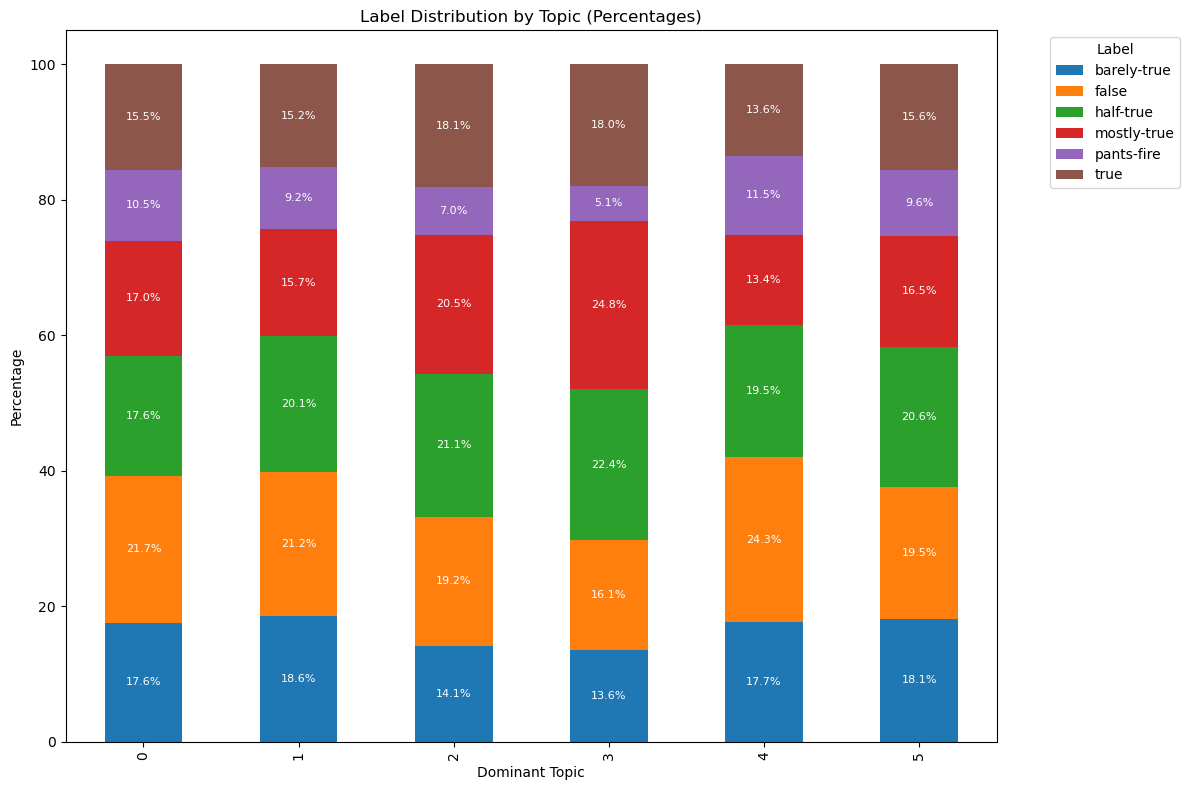

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Calculate the percentage distribution within each topic
label_distribution_percentages = label_distribution_by_topic.div(label_distribution_by_topic.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
fig, ax = plt.subplots(figsize=(12, 8))
label_distribution_percentages.plot(kind='bar', stacked=True, ax=ax)

# Add percentages on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only label non-zero segments
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8, color='white')

# Move the legend outside the plot
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Label Distribution by Topic (Percentages)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()


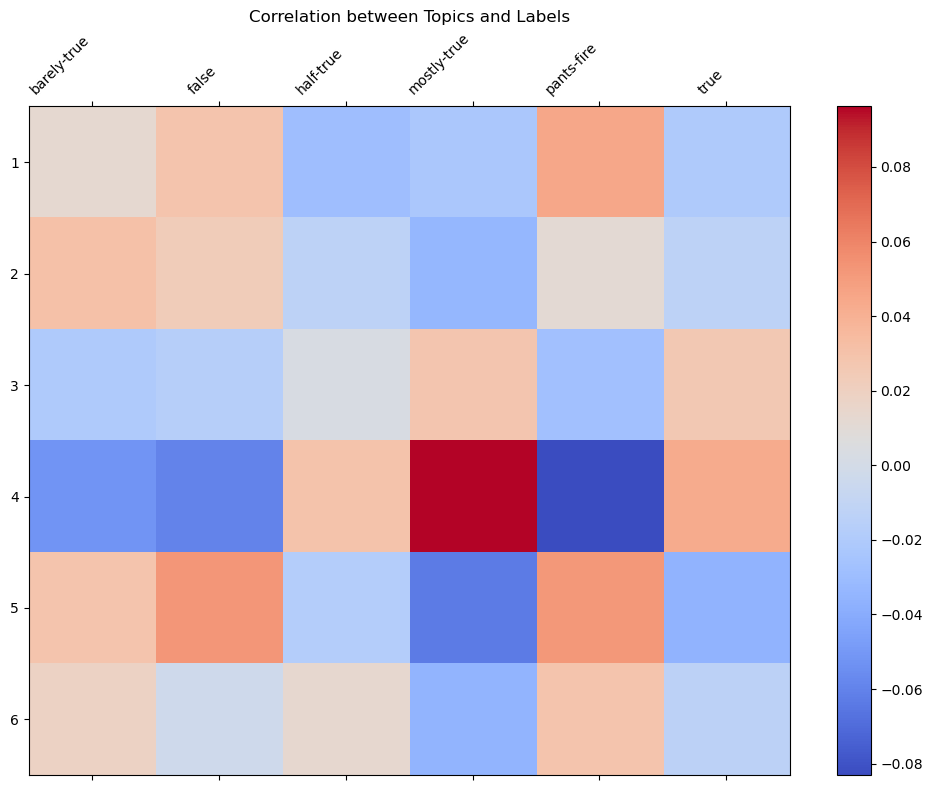

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Convert topic distributions to a DataFrame
topic_df = pd.DataFrame([dict(dist) for dist in topic_distributions])

# Add the labels to the DataFrame
topic_df['label'] = train_data['label'].values

# One-hot encode the labels for correlation calculation
label_encoded = pd.get_dummies(topic_df['label'])

# Initialize an empty DataFrame to store the correlations
correlation_df = pd.DataFrame(index=topic_df.columns[:-1], columns=label_encoded.columns)

# Calculate the correlation between each topic and each label
for topic in correlation_df.index:
    for label in correlation_df.columns:
        correlation_df.loc[topic, label] = topic_df[topic].corr(label_encoded[label])

# Convert to float (correlations are numeric)
correlation_df = correlation_df.astype(float)

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_df, cmap='coolwarm', aspect='auto')

# Add a colorbar
fig.colorbar(cax)

# Set the x-axis and y-axis labels
ax.set_xticks(range(len(correlation_df.columns)))
ax.set_yticks(range(len(correlation_df.index)))
ax.set_xticklabels(correlation_df.columns, rotation=45, ha='right')

# Adjust the y-axis labels to display 1-6 instead of 0-5
ax.set_yticklabels(range(1, 7))

plt.title('Correlation between Topics and Labels')
plt.tight_layout()

plt.show()


In [24]:
# add the dominant topic to each sample of the train data
import pandas as pd
import numpy as np

# Get the topic distribution for each document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Display the first few rows of the updated DataFrame to verify the result
display(train_data)



,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context,processed_text,dominant_topic
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"[say, annies, list, political, group, support,...",1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...",5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"[health, care, reform, legislation, likely, ma...",0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5473.json,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""","[larger, number, shark, attack, florida, case,...",4
10236,3408.json,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,"[democrat, become, party, atlanta, metro, area...",2
10237,3959.json,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,"[say, alternative, social, security, operates,...",1
10238,2253.json,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,"[lifting, cuban, embargo, allowing, travel, cuba]",2


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7342 non-null   object 
 6   state            8030 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
 14  processed_text   10240 non-null  object 
 15  dominant_topic   10240 non-null  int64  
dtypes: float64(5), int64(1), object(10)
memory usage: 1.3+ MB


# Feature selection 
- Feature selection is the process of selecting a subset of relevant features for use in model construction.


In [25]:
# get info on party column, the different values and the number of samples for each value
train_data['party'].value_counts()

party
republican                      4497
democrat                        3336
none                            1744
organization                     219
independent                      147
newsmaker                         56
libertarian                       40
activist                          39
journalist                        38
columnist                         35
talk-show-host                    26
state-official                    20
labor-leader                      11
tea-party-member                  10
business-leader                    9
green                              3
education-official                 2
liberal-party-canada               1
government-body                    1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
constitution-party                 1
Name: count, dtype: int64

In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'party' column
train_data['party_encoded'] = label_encoder.fit_transform(train_data['party'])

# Display the first few rows to verify the result
display(train_data.head())




c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,statement_id,label,statement,subject,speaker,job_title,state,party,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c,context,processed_text,dominant_topic,party_encoded
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,"[say, annies, list, political, group, support,...",1,19
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"[decline, coal, start, started, natural, gas, ...",5,5
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,"[hillary, clinton, agrees, john, mccain, votin...",5,5
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,"[health, care, reform, legislation, likely, ma...",0,16
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"[economic, turnaround, started, end, term]",5,5
